# Task Overview

Your task will be to implement a variant of *ProxyProp* (Proximal Backpropagation) – a modification of backpropagation in which the weights of the network are not updated according to gradient descent, but according to [proximal mapping operator](https://en.wikipedia.org/wiki/Proximal_operator). This proximal operator in many cases results in a descent that is quicker than in the case of traditional gradient descent. Interestingly enough, the proximal operator arose in the context of gradient descent in which the minimized function is not differentiable, and gradient descent cannot be applied directly as we cannot compute the Jacobi matrix. This method is called [proximal gradient method](https://en.wikipedia.org/wiki/Proximal_gradient_method). However, we are interested here in the efficiency of the approach rather than its robustness. The backpropagation method in the proximal approach (i.e. *ProxyProp* algorithm) is described in detail in [this paper](https://arxiv.org/pdf/1706.04638v3).

The original algorithm presented in the paper uses purely linear transformations between subsequent network layers. Part of your task is to use affine transformations there, i.e. ones with biases.

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (9pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 6pt implement the backpropagation
2. Train the models (find proper hyperparameters). Visualize the learning speed of your best model compared with the standard backpropagation (plot training loss for subsequent numbers of epochs using both algorithms). Your model should reach at least 94% accuracy. Use ClearML to log your scores. Make a comparison of memory usage for _ProxProp_ network and the network you implemented in lab 3.
  - 1pt for accuracy above 94%
  - 1pt for initialization of the standard backpropagation and ProxyProp with the same random values
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.

Part of the assignment consists of deriving proper formulas for a proposed slight modification of _ProxProp_. We do not grant points separately for this activity. You are rewarded for that only after proper implementation.


## Potential questions, clarifications
- Q: Can I modify code of _ProxyProp_ outside #Your code goes here # to include logging?
  - Yes, in ProxyProp.SGD
- Q: Can I modify the code of _Network_ to include logging?
  - Yes.

In [ ]:
%pip install clearml
%pip install memory-profiler
%pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.2 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.9.0
    Uninstalling PyJWT-2.9.0:
      Successfully uninstalled PyJWT-2.9.0


In [ ]:
import numpy as np
from clearml import Logger, Task
from typing import List
import plotly.graph_objects as go
import plotly.subplots as sp
import matplotlib.pyplot as plt

In [ ]:
%load_ext memory_profiler

# Dataset loading


In [ ]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2024-11-18 15:26:21--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.165.144, 52.217.233.8, 54.231.163.208, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.165.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  37.8MB/s    in 0.3s    

2024-11-18 15:26:21 (37.8 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [ ]:
def load_mnist(path: str = "mnist.npz"):
    with np.load(path) as f:
        x_train, _y_train = f["x_train"], f["y_train"]
        x_test, _y_test = f["x_test"], f["y_test"]

    x_train = x_train.reshape(-1, 28 * 28) / 255.0
    x_test = x_test.reshape(-1, 28 * 28) / 255.0

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [ ]:
### Your code goes here ###
CLEARML_WEB_HOST="https://app.clear.ml/"
CLEARML_API_HOST="https://api.clear.ml"
CLEARML_FILES_HOST="https://files.clear.ml"
CLEARML_API_ACCESS_KEY=""
CLEARML_API_SECRET_KEY=""

Task.set_credentials(
    api_host=CLEARML_API_HOST,
    web_host=CLEARML_WEB_HOST,
    files_host=CLEARML_FILES_HOST,
    key=CLEARML_API_ACCESS_KEY,
    secret=CLEARML_API_SECRET_KEY)

task = Task.init(
    project_name='hw1-proxprop',
    task_name='Track experiment progress',
)

params_proxprop = {
    'epochs': 11,
    'mini_batch_size': 100,
    'learning_rate': 8.5,
    'layers': [784, 128, 128, 10]
}

params_network = {
    'epochs': 11,
    'mini_batch_size': 100,
    'learning_rate': 4.46,
    'layers': [784, 128, 128, 10]
}
###########################

ClearML Task: created new task id=821665df99c345aaabe51325a97fa24d
ClearML results page: https://app.clear.ml/projects/ff006901144142bb8c405652097fd6e7/experiments/821665df99c345aaabe51325a97fa24d/output/log


# A quick recap of the backpropagation model

## Forward pass

We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

To compute gradients, use the following formulas:

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial b^{(l)}} = \frac{\partial L}{\partial f^{(l)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial W^{(l)}} = \frac{\partial L}{\partial f^{(l)}} \cdot g^{(l-1)}
\nonumber
%\end{equation}
$$

$l = L, L-1, \ldots, 1$.

# Network definition (as in laboratory 3)


In [ ]:
def sigmoid(z: np.ndarray) -> float:
    return 1.0 / (1.0 + np.exp(-z))

def logloss(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    return -(np.log(x) * y).sum() / y.shape[1]

In [ ]:
class Network(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a

    def update_mini_batch(
        self,
        mini_batch: tuple[np.ndarray, np.ndarray],
        eta: float,
    ):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w, loss = self.backprop(mini_batch[0].T, mini_batch[1].T)

        self.weights = [
            w - (eta / len(mini_batch[0])) * nw for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - (eta / len(mini_batch[0])) * nb for b, nb in zip(self.biases, nabla_b)
        ]
        return loss

    def backprop(
        self,
        x: np.ndarray,
        y: np.ndarray,
    ) -> tuple[np.ndarray, np.ndarray, float]:
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w, g in reversed(list(zip(self.weights, gs[1:]))):
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf, g.T) for dLdf, g in zip(reversed(dLdfs), gs[:-1])]
        dLdBs = [
            np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) for dLdf in reversed(dLdfs)
        ]
        return (dLdBs, dLdWs, loss)

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        wloss = logloss(self.feedforward(x_train).T, y_train) / (
            x_train.shape[0] // mini_batch_size
        )
        for j in range(epochs + 1):
            if logger is not None:
                logger.report_scalar("Loss", "Network Loss", iteration = j, value = wloss)
            if test_data:
                acc = self.evaluate((x_test, y_test))
                if logger is not None:
                    logger.report_scalar("Accuracy", "Network Accuracy", iteration=j, value=acc)
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if j == epochs:
                break
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            wloss = loss / (x_train.shape[0] // mini_batch_size)


# Simple check if all is fine
network = Network([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.1063, Loss: 18.957186551483506
Epoch: 1, Accuracy: 0.8103, Loss: 1.28167925481337
Epoch: 2, Accuracy: 0.8613, Loss: 0.6237174854129596


In [ ]:
# This is the second iteration of the optuna to find the optimal eta for basic_network.

import optuna
from sklearn.metrics import accuracy_score

seed = 1234
np.random.seed(seed)
basic_network = Network(params_network['layers'])

def objective(trial):
    eta = trial.suggest_uniform('learning_rate', 0.5, 5)
                #suggest_loguniform('learning_rate', 1e-2, 10)
    np.random.seed(seed)
    basic_network = Network(params_network['layers'])

    basic_network.SGD(
        (x_train, y_train),
        epochs=params_network['epochs'],
        mini_batch_size=params_network['mini_batch_size'],
        eta=eta,
        test_data=(x_test, y_test),
        logger=None
    )


    accuracy = basic_network.evaluate((x_test, y_test))
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_eta = study.best_params['learning_rate']
print(f"Optimal learning rate: {best_eta}")
# optimal lr = 4.463510031132314

[I 2024-11-13 13:40:26,044] A new study created in memory with name: no-name-bd024383-1eb0-4ce7-a086-d5a95bb2f20e
<ipython-input-13-c2735bfc747c>:7: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



Epoch: 0, Accuracy: 0.5593, Loss: 7.65925940325002
Epoch: 1, Accuracy: 0.7357, Loss: 4.499221930804718
Epoch: 2, Accuracy: 0.7527, Loss: 3.287491363483617
Epoch: 3, Accuracy: 0.7754, Loss: 3.073319457458103
Epoch: 4, Accuracy: 0.8289, Loss: 2.2862602502480183
Epoch: 5, Accuracy: 0.838, Loss: 2.063551339366414
Epoch: 6, Accuracy: 0.8421, Loss: 1.9934791676130423
Epoch: 7, Accuracy: 0.8441, Loss: 1.9532135233330201
Epoch: 8, Accuracy: 0.8459, Loss: 1.9201881153090217
Epoch: 9, Accuracy: 0.8475, Loss: 1.8939907109589922


[I 2024-11-13 13:41:24,693] Trial 0 finished with value: 0.8475 and parameters: {'learning_rate': 4.499247933570683}. Best is trial 0 with value: 0.8475.


Epoch: 0, Accuracy: 0.1139, Loss: 5.102651838692374
Epoch: 1, Accuracy: 0.1135, Loss: 2.439288767617073
Epoch: 2, Accuracy: 0.1135, Loss: 2.1308783839198773
Epoch: 3, Accuracy: 0.1135, Loss: 2.0701261379833085
Epoch: 4, Accuracy: 0.1135, Loss: 2.0327245436356773
Epoch: 5, Accuracy: 0.1135, Loss: 2.0067055066344475
Epoch: 6, Accuracy: 0.1135, Loss: 1.988125646005502
Epoch: 7, Accuracy: 0.1135, Loss: 1.972801581751263
Epoch: 8, Accuracy: 0.1136, Loss: 1.9602569791680253


[I 2024-11-13 13:42:22,772] Trial 1 finished with value: 0.1138 and parameters: {'learning_rate': 2.22965411749858}. Best is trial 0 with value: 0.8475.


Epoch: 9, Accuracy: 0.1138, Loss: 1.9485745573070414
Epoch: 0, Accuracy: 0.2945, Loss: 10.132885595050862
Epoch: 1, Accuracy: 0.4981, Loss: 8.098521362046196
Epoch: 2, Accuracy: 0.6573, Loss: 5.045456553985845
Epoch: 3, Accuracy: 0.6648, Loss: 4.935925478133458
Epoch: 4, Accuracy: 0.6693, Loss: 4.909475850767727
Epoch: 5, Accuracy: 0.6728, Loss: 4.875900980686457
Epoch: 6, Accuracy: 0.6737, Loss: 4.844856091494029
Epoch: 7, Accuracy: 0.6759, Loss: 4.821532692342245
Epoch: 8, Accuracy: 0.677, Loss: 4.81053807161492


[I 2024-11-13 13:43:18,478] Trial 2 finished with value: 0.6785 and parameters: {'learning_rate': 4.932165694082645}. Best is trial 0 with value: 0.8475.


Epoch: 9, Accuracy: 0.6785, Loss: 4.802650840668936
Epoch: 0, Accuracy: 0.1135, Loss: 5.728575193069477
Epoch: 1, Accuracy: 0.1135, Loss: 4.365077824565903
Epoch: 2, Accuracy: 0.1135, Loss: 3.244926229726227
Epoch: 3, Accuracy: 0.1135, Loss: 2.5012169839306293
Epoch: 4, Accuracy: 0.1135, Loss: 2.281504519659434
Epoch: 5, Accuracy: 0.1135, Loss: 2.1733965306420275
Epoch: 6, Accuracy: 0.1135, Loss: 2.117368567809974
Epoch: 7, Accuracy: 0.1135, Loss: 2.0775463791588917
Epoch: 8, Accuracy: 0.1135, Loss: 2.0474521288583247


[I 2024-11-13 13:44:10,953] Trial 3 finished with value: 0.1135 and parameters: {'learning_rate': 0.5905105552026403}. Best is trial 0 with value: 0.8475.


Epoch: 9, Accuracy: 0.1135, Loss: 2.0263805721975627
Epoch: 0, Accuracy: 0.114, Loss: 5.661605150683514
Epoch: 1, Accuracy: 0.1143, Loss: 2.8062301817471678
Epoch: 2, Accuracy: 0.1175, Loss: 2.1385279092890634
Epoch: 3, Accuracy: 0.7175, Loss: 2.925072057431923
Epoch: 4, Accuracy: 0.7228, Loss: 3.5491807168725056
Epoch: 5, Accuracy: 0.7269, Loss: 3.6218404657311125
Epoch: 6, Accuracy: 0.7294, Loss: 3.668206936284277
Epoch: 7, Accuracy: 0.7315, Loss: 3.7043931839592528
Epoch: 8, Accuracy: 0.7334, Loss: 3.730621540593438
Epoch: 9, Accuracy: 0.7359, Loss: 3.748742600069526


[I 2024-11-13 13:45:08,484] Trial 4 finished with value: 0.7359 and parameters: {'learning_rate': 3.1513836858264384}. Best is trial 0 with value: 0.8475.


Epoch: 0, Accuracy: 0.1145, Loss: 5.481522585585245
Epoch: 1, Accuracy: 0.1149, Loss: 3.0130803307553076
Epoch: 2, Accuracy: 0.6976, Loss: 2.675641688840693
Epoch: 3, Accuracy: 0.7101, Loss: 3.3358360318925655
Epoch: 4, Accuracy: 0.7181, Loss: 3.3564748857116546
Epoch: 5, Accuracy: 0.7231, Loss: 3.354939973614955
Epoch: 6, Accuracy: 0.7259, Loss: 3.3455687646698307
Epoch: 7, Accuracy: 0.7284, Loss: 3.3390817834330493
Epoch: 8, Accuracy: 0.7304, Loss: 3.3270531926167326
Epoch: 9, Accuracy: 0.732, Loss: 3.3063590031783914


[I 2024-11-13 13:46:04,410] Trial 5 finished with value: 0.732 and parameters: {'learning_rate': 2.6456553057163137}. Best is trial 0 with value: 0.8475.


Epoch: 0, Accuracy: 0.1137, Loss: 5.4217030388732095
Epoch: 1, Accuracy: 0.1138, Loss: 3.160911883157865
Epoch: 2, Accuracy: 0.1137, Loss: 2.2297643434966137
Epoch: 3, Accuracy: 0.1137, Loss: 2.1204569725557056
Epoch: 4, Accuracy: 0.1139, Loss: 2.0690435187904637
Epoch: 5, Accuracy: 0.1143, Loss: 2.0427756087874167
Epoch: 6, Accuracy: 0.1148, Loss: 2.026812141600609
Epoch: 7, Accuracy: 0.1152, Loss: 2.012836704005238
Epoch: 8, Accuracy: 0.1171, Loss: 1.9999047579822056
Epoch: 9, Accuracy: 0.1198, Loss: 1.9902839874997365


[I 2024-11-13 13:47:00,620] Trial 6 finished with value: 0.1198 and parameters: {'learning_rate': 1.391403399385029}. Best is trial 0 with value: 0.8475.


Epoch: 0, Accuracy: 0.1141, Loss: 5.13997852176272
Epoch: 1, Accuracy: 0.1135, Loss: 2.448137479470042
Epoch: 2, Accuracy: 0.1135, Loss: 2.2114299677154294
Epoch: 3, Accuracy: 0.1135, Loss: 2.1408075521259966
Epoch: 4, Accuracy: 0.1136, Loss: 2.096765253027802
Epoch: 5, Accuracy: 0.1136, Loss: 2.0730787970163207
Epoch: 6, Accuracy: 0.1138, Loss: 2.058675949810106
Epoch: 7, Accuracy: 0.1148, Loss: 2.0481822037970883
Epoch: 8, Accuracy: 0.1161, Loss: 2.0367280258639777


[I 2024-11-13 13:47:55,850] Trial 7 finished with value: 0.1337 and parameters: {'learning_rate': 2.4516594795851194}. Best is trial 0 with value: 0.8475.


Epoch: 9, Accuracy: 0.1337, Loss: 2.023493010539115
Epoch: 0, Accuracy: 0.5554, Loss: 7.859467111167953
Epoch: 1, Accuracy: 0.6292, Loss: 5.607579394937465
Epoch: 2, Accuracy: 0.6613, Loss: 4.538940451648934
Epoch: 3, Accuracy: 0.7417, Loss: 4.212498123584594
Epoch: 4, Accuracy: 0.7601, Loss: 3.2436315586730253
Epoch: 5, Accuracy: 0.7647, Loss: 3.094367434456635
Epoch: 6, Accuracy: 0.8229, Loss: 2.764047011551093
Epoch: 7, Accuracy: 0.8401, Loss: 2.159260046903105
Epoch: 8, Accuracy: 0.8434, Loss: 2.0819614451409145


[I 2024-11-13 13:48:48,984] Trial 8 finished with value: 0.846 and parameters: {'learning_rate': 4.619500015120679}. Best is trial 0 with value: 0.8475.


Epoch: 9, Accuracy: 0.846, Loss: 2.048437308956884
Epoch: 0, Accuracy: 0.1145, Loss: 5.4084755368609505
Epoch: 1, Accuracy: 0.1141, Loss: 2.864782821987602
Epoch: 2, Accuracy: 0.1143, Loss: 2.2452299048222177
Epoch: 3, Accuracy: 0.711, Loss: 2.538042667357094
Epoch: 4, Accuracy: 0.7171, Loss: 3.3450821339862706
Epoch: 5, Accuracy: 0.7224, Loss: 3.4027453909756753
Epoch: 6, Accuracy: 0.7263, Loss: 3.416634522156484
Epoch: 7, Accuracy: 0.7285, Loss: 3.4253637998101505
Epoch: 8, Accuracy: 0.7311, Loss: 3.429803457812509


[I 2024-11-13 13:49:43,873] Trial 9 finished with value: 0.7317 and parameters: {'learning_rate': 2.5860234517634115}. Best is trial 0 with value: 0.8475.


Epoch: 9, Accuracy: 0.7317, Loss: 3.4295385195246832
Epoch: 0, Accuracy: 0.6351, Loss: 6.5001862194308195
Epoch: 1, Accuracy: 0.7367, Loss: 3.790729798464071
Epoch: 2, Accuracy: 0.8029, Loss: 2.609708850762317
Epoch: 3, Accuracy: 0.8222, Loss: 2.193183544769939
Epoch: 4, Accuracy: 0.8313, Loss: 2.1101315379929093
Epoch: 5, Accuracy: 0.8373, Loss: 2.071102161886964
Epoch: 6, Accuracy: 0.8411, Loss: 2.0499672646944385
Epoch: 7, Accuracy: 0.8441, Loss: 2.0376859277514088
Epoch: 8, Accuracy: 0.8454, Loss: 2.026364926066755
Epoch: 9, Accuracy: 0.8468, Loss: 2.0159659054767505


[I 2024-11-13 13:50:36,608] Trial 10 finished with value: 0.8468 and parameters: {'learning_rate': 3.8884674143539115}. Best is trial 0 with value: 0.8475.


Epoch: 0, Accuracy: 0.6345, Loss: 6.532434954362278
Epoch: 1, Accuracy: 0.7761, Loss: 3.053831103240366
Epoch: 2, Accuracy: 0.8167, Loss: 2.225244678716566
Epoch: 3, Accuracy: 0.8271, Loss: 2.086198339067448
Epoch: 4, Accuracy: 0.835, Loss: 2.0423822060405046
Epoch: 5, Accuracy: 0.8383, Loss: 2.0162280207427736
Epoch: 6, Accuracy: 0.8422, Loss: 1.9988481559153806
Epoch: 7, Accuracy: 0.8456, Loss: 1.98504544071086
Epoch: 8, Accuracy: 0.847, Loss: 1.9727239656447015
Epoch: 9, Accuracy: 0.8473, Loss: 1.9624092373566744


[I 2024-11-13 13:51:34,465] Trial 11 finished with value: 0.8473 and parameters: {'learning_rate': 3.8276369646914383}. Best is trial 0 with value: 0.8475.


Epoch: 0, Accuracy: 0.6382, Loss: 6.518059248711311
Epoch: 1, Accuracy: 0.7406, Loss: 3.6373858152917227
Epoch: 2, Accuracy: 0.8082, Loss: 2.585229139765259
Epoch: 3, Accuracy: 0.8261, Loss: 2.187617758910964
Epoch: 4, Accuracy: 0.8341, Loss: 2.115716608595343
Epoch: 5, Accuracy: 0.8395, Loss: 2.081614707674992
Epoch: 6, Accuracy: 0.8421, Loss: 2.0613112160492326
Epoch: 7, Accuracy: 0.8446, Loss: 2.046557308226976
Epoch: 8, Accuracy: 0.8467, Loss: 2.0352941128677386
Epoch: 9, Accuracy: 0.8476, Loss: 2.0265059275741275


[I 2024-11-13 13:52:35,422] Trial 12 finished with value: 0.8476 and parameters: {'learning_rate': 3.92806736276044}. Best is trial 12 with value: 0.8476.


Epoch: 0, Accuracy: 0.5698, Loss: 6.897325699480146
Epoch: 1, Accuracy: 0.7913, Loss: 2.9203745398960574
Epoch: 2, Accuracy: 0.8203, Loss: 2.2565831705357935
Epoch: 3, Accuracy: 0.8304, Loss: 2.170574712337667
Epoch: 4, Accuracy: 0.8357, Loss: 2.1347078825554435
Epoch: 5, Accuracy: 0.8379, Loss: 2.106299519606682
Epoch: 6, Accuracy: 0.8405, Loss: 2.0841091634367643
Epoch: 7, Accuracy: 0.8432, Loss: 2.0650806153780463
Epoch: 8, Accuracy: 0.8453, Loss: 2.0480045760526138
Epoch: 9, Accuracy: 0.8458, Loss: 2.036439549981739


[I 2024-11-13 13:53:30,054] Trial 13 finished with value: 0.8458 and parameters: {'learning_rate': 4.189757371926052}. Best is trial 12 with value: 0.8476.


Epoch: 0, Accuracy: 0.569, Loss: 5.8877113475536635
Epoch: 1, Accuracy: 0.787, Loss: 2.664425955765401
Epoch: 2, Accuracy: 0.817, Loss: 2.16454916178253
Epoch: 3, Accuracy: 0.8285, Loss: 2.077152242416373
Epoch: 4, Accuracy: 0.8336, Loss: 2.044464066457138
Epoch: 5, Accuracy: 0.84, Loss: 2.0193356861761176
Epoch: 6, Accuracy: 0.8422, Loss: 1.999498247239718
Epoch: 7, Accuracy: 0.8445, Loss: 1.9813829806023535
Epoch: 8, Accuracy: 0.8459, Loss: 1.9651891813036628


[I 2024-11-13 13:54:36,188] Trial 14 finished with value: 0.8475 and parameters: {'learning_rate': 3.3902420231067225}. Best is trial 12 with value: 0.8476.


Epoch: 9, Accuracy: 0.8475, Loss: 1.9505752624854482
Epoch: 0, Accuracy: 0.4841, Loss: 7.4922157639505285
Epoch: 1, Accuracy: 0.7366, Loss: 4.037871043745417
Epoch: 2, Accuracy: 0.7537, Loss: 3.2145426474595613
Epoch: 3, Accuracy: 0.7588, Loss: 3.1094044712895603
Epoch: 4, Accuracy: 0.7631, Loss: 2.9901861588510967
Epoch: 5, Accuracy: 0.8261, Loss: 2.414704421370042
Epoch: 6, Accuracy: 0.8386, Loss: 2.0389865534300116
Epoch: 7, Accuracy: 0.8425, Loss: 1.986960573933485
Epoch: 8, Accuracy: 0.8452, Loss: 1.9518151594654547
Epoch: 9, Accuracy: 0.8482, Loss: 1.9218597190417643


[I 2024-11-13 13:55:30,393] Trial 15 finished with value: 0.8482 and parameters: {'learning_rate': 4.4080501197907}. Best is trial 15 with value: 0.8482.


Epoch: 0, Accuracy: 0.5676, Loss: 5.844326914053087
Epoch: 1, Accuracy: 0.7893, Loss: 2.636054078729963
Epoch: 2, Accuracy: 0.8161, Loss: 2.132144019200285
Epoch: 3, Accuracy: 0.8245, Loss: 2.049377067704665
Epoch: 4, Accuracy: 0.8316, Loss: 2.0098615493442145
Epoch: 5, Accuracy: 0.8375, Loss: 1.9824422464604716
Epoch: 6, Accuracy: 0.8411, Loss: 1.9603765536411617
Epoch: 7, Accuracy: 0.8428, Loss: 1.9444297348661435
Epoch: 8, Accuracy: 0.8449, Loss: 1.9322793677903978
Epoch: 9, Accuracy: 0.8464, Loss: 1.9208742461406272


[I 2024-11-13 13:56:24,129] Trial 16 finished with value: 0.8464 and parameters: {'learning_rate': 3.3647058676883788}. Best is trial 15 with value: 0.8482.


Epoch: 0, Accuracy: 0.6315, Loss: 6.396589668895645
Epoch: 1, Accuracy: 0.78, Loss: 3.196560155366586
Epoch: 2, Accuracy: 0.8136, Loss: 2.235959454986764
Epoch: 3, Accuracy: 0.8259, Loss: 2.0956626261675226
Epoch: 4, Accuracy: 0.8312, Loss: 2.054864495895965
Epoch: 5, Accuracy: 0.8357, Loss: 2.0321313295248733
Epoch: 6, Accuracy: 0.8382, Loss: 2.022714426474299
Epoch: 7, Accuracy: 0.8408, Loss: 2.0168165989169053
Epoch: 8, Accuracy: 0.8429, Loss: 2.01044519828387
Epoch: 9, Accuracy: 0.8451, Loss: 2.0063734511988307


[I 2024-11-13 13:57:15,959] Trial 17 finished with value: 0.8451 and parameters: {'learning_rate': 3.820995493821611}. Best is trial 15 with value: 0.8482.


Epoch: 0, Accuracy: 0.4658, Loss: 9.374891200278794
Epoch: 1, Accuracy: 0.5771, Loss: 6.555476374849037
Epoch: 2, Accuracy: 0.6603, Loss: 4.959720992809543
Epoch: 3, Accuracy: 0.669, Loss: 4.793389197103272
Epoch: 4, Accuracy: 0.6713, Loss: 4.72890143739356
Epoch: 5, Accuracy: 0.6757, Loss: 4.644822347838843
Epoch: 6, Accuracy: 0.6962, Loss: 4.475770664431323
Epoch: 7, Accuracy: 0.7514, Loss: 3.6818274973217884
Epoch: 8, Accuracy: 0.7556, Loss: 3.5100699922775593


[I 2024-11-13 13:58:10,535] Trial 18 finished with value: 0.7579 and parameters: {'learning_rate': 4.972527689015101}. Best is trial 15 with value: 0.8482.


Epoch: 9, Accuracy: 0.7579, Loss: 3.4939763217356057
Epoch: 0, Accuracy: 0.5606, Loss: 7.172589669261841
Epoch: 1, Accuracy: 0.7383, Loss: 4.113064542435737
Epoch: 2, Accuracy: 0.8065, Loss: 2.6522493145920887
Epoch: 3, Accuracy: 0.8294, Loss: 2.1942066076404756
Epoch: 4, Accuracy: 0.8365, Loss: 2.113054674156133
Epoch: 5, Accuracy: 0.8408, Loss: 2.0932858962975556
Epoch: 6, Accuracy: 0.8433, Loss: 2.084569238880561
Epoch: 7, Accuracy: 0.8454, Loss: 2.075926930165449
Epoch: 8, Accuracy: 0.8479, Loss: 2.067696650868941
Epoch: 9, Accuracy: 0.8493, Loss: 2.0615776893803552


[I 2024-11-13 13:59:06,909] Trial 19 finished with value: 0.8493 and parameters: {'learning_rate': 4.299491040440157}. Best is trial 19 with value: 0.8493.


Epoch: 0, Accuracy: 0.1139, Loss: 5.141800946802285
Epoch: 1, Accuracy: 0.1135, Loss: 2.511018075431829
Epoch: 2, Accuracy: 0.1135, Loss: 2.118967331426317
Epoch: 3, Accuracy: 0.1135, Loss: 2.050811690305188
Epoch: 4, Accuracy: 0.1135, Loss: 2.0084021993271617
Epoch: 5, Accuracy: 0.1135, Loss: 1.9769252624892548
Epoch: 6, Accuracy: 0.1136, Loss: 1.9536916872422285
Epoch: 7, Accuracy: 0.1137, Loss: 1.9379597203568109
Epoch: 8, Accuracy: 0.1137, Loss: 1.9260567329001097


[I 2024-11-13 13:59:59,281] Trial 20 finished with value: 0.1137 and parameters: {'learning_rate': 1.9936210752071426}. Best is trial 19 with value: 0.8493.


Epoch: 9, Accuracy: 0.1137, Loss: 1.9163934776792704
Epoch: 0, Accuracy: 0.562, Loss: 7.089110132560833
Epoch: 1, Accuracy: 0.7588, Loss: 3.687016063217289
Epoch: 2, Accuracy: 0.8162, Loss: 2.290797802900797
Epoch: 3, Accuracy: 0.8303, Loss: 2.113459657462003
Epoch: 4, Accuracy: 0.837, Loss: 2.0594640818619636
Epoch: 5, Accuracy: 0.8409, Loss: 2.023205127642
Epoch: 6, Accuracy: 0.8427, Loss: 1.9990090556270215
Epoch: 7, Accuracy: 0.8443, Loss: 1.9773855369282896
Epoch: 8, Accuracy: 0.847, Loss: 1.9575511320649237
Epoch: 9, Accuracy: 0.8485, Loss: 1.940111993271723


[I 2024-11-13 14:00:55,583] Trial 21 finished with value: 0.8485 and parameters: {'learning_rate': 4.2836905143583826}. Best is trial 19 with value: 0.8493.


Epoch: 0, Accuracy: 0.4826, Loss: 7.5700565922756216
Epoch: 1, Accuracy: 0.7391, Loss: 3.825979670298984
Epoch: 2, Accuracy: 0.8039, Loss: 2.8372407958745907
Epoch: 3, Accuracy: 0.8266, Loss: 2.1804629135523905
Epoch: 4, Accuracy: 0.835, Loss: 2.0684349466762284
Epoch: 5, Accuracy: 0.8395, Loss: 2.0238549523957996
Epoch: 6, Accuracy: 0.8424, Loss: 1.994676602454692
Epoch: 7, Accuracy: 0.8452, Loss: 1.9698069142198842
Epoch: 8, Accuracy: 0.8459, Loss: 1.949874846401553
Epoch: 9, Accuracy: 0.8474, Loss: 1.935803888027007


[I 2024-11-13 14:01:47,435] Trial 22 finished with value: 0.8474 and parameters: {'learning_rate': 4.409500209329753}. Best is trial 19 with value: 0.8493.


Epoch: 0, Accuracy: 0.563, Loss: 7.113797793933265
Epoch: 1, Accuracy: 0.7666, Loss: 3.5318305009771205
Epoch: 2, Accuracy: 0.8182, Loss: 2.221329481106862
Epoch: 3, Accuracy: 0.8297, Loss: 2.0416619095354953
Epoch: 4, Accuracy: 0.8359, Loss: 1.9768771017673066
Epoch: 5, Accuracy: 0.8389, Loss: 1.9404791454618768
Epoch: 6, Accuracy: 0.8421, Loss: 1.9127598828213797
Epoch: 7, Accuracy: 0.8454, Loss: 1.8878007830637897
Epoch: 8, Accuracy: 0.8476, Loss: 1.8664152592773902


[I 2024-11-13 14:02:46,903] Trial 23 finished with value: 0.8484 and parameters: {'learning_rate': 4.24896038899528}. Best is trial 19 with value: 0.8493.


Epoch: 9, Accuracy: 0.8484, Loss: 1.8469077676821277
Epoch: 0, Accuracy: 0.6404, Loss: 6.661312513992688
Epoch: 1, Accuracy: 0.7917, Loss: 2.838318898798253
Epoch: 2, Accuracy: 0.8206, Loss: 2.3254048935137437
Epoch: 3, Accuracy: 0.8306, Loss: 2.241217602427855
Epoch: 4, Accuracy: 0.8367, Loss: 2.2072529982330895
Epoch: 5, Accuracy: 0.8397, Loss: 2.1858071401806485
Epoch: 6, Accuracy: 0.8428, Loss: 2.169872539762159
Epoch: 7, Accuracy: 0.8453, Loss: 2.157317896182047
Epoch: 8, Accuracy: 0.8471, Loss: 2.1486147273803287
Epoch: 9, Accuracy: 0.8482, Loss: 2.1437122403920137


[I 2024-11-13 14:03:42,461] Trial 24 finished with value: 0.8482 and parameters: {'learning_rate': 4.14364102922249}. Best is trial 19 with value: 0.8493.


Epoch: 0, Accuracy: 0.1141, Loss: 5.6892699684237975
Epoch: 1, Accuracy: 0.1661, Loss: 2.890662376971793
Epoch: 2, Accuracy: 0.8144, Loss: 2.2509119180044985
Epoch: 3, Accuracy: 0.8257, Loss: 2.0893092889506786
Epoch: 4, Accuracy: 0.8323, Loss: 2.0482207754543325
Epoch: 5, Accuracy: 0.8362, Loss: 2.0217956702093813
Epoch: 6, Accuracy: 0.8405, Loss: 1.9992115095872272
Epoch: 7, Accuracy: 0.8419, Loss: 1.9789476219669129
Epoch: 8, Accuracy: 0.844, Loss: 1.9620817465421203
Epoch: 9, Accuracy: 0.8459, Loss: 1.9505516540672074


[I 2024-11-13 14:04:34,410] Trial 25 finished with value: 0.8459 and parameters: {'learning_rate': 3.126330943358343}. Best is trial 19 with value: 0.8493.


Epoch: 0, Accuracy: 0.114, Loss: 6.041439632636434
Epoch: 1, Accuracy: 0.1135, Loss: 2.5285499469167045
Epoch: 2, Accuracy: 0.1136, Loss: 2.173203536658009
Epoch: 3, Accuracy: 0.1142, Loss: 2.091746146586506
Epoch: 4, Accuracy: 0.1163, Loss: 2.0631662295153648
Epoch: 5, Accuracy: 0.728, Loss: 2.705220242783599
Epoch: 6, Accuracy: 0.7301, Loss: 3.5950422517213836
Epoch: 7, Accuracy: 0.7326, Loss: 3.6482234729117597
Epoch: 8, Accuracy: 0.736, Loss: 3.642586825077895
Epoch: 9, Accuracy: 0.737, Loss: 3.642409345237518


[I 2024-11-13 14:05:43,674] Trial 26 finished with value: 0.737 and parameters: {'learning_rate': 3.5693214505517563}. Best is trial 19 with value: 0.8493.


Epoch: 0, Accuracy: 0.4726, Loss: 8.744667075299354
Epoch: 1, Accuracy: 0.5698, Loss: 6.8470075205390515
Epoch: 2, Accuracy: 0.5803, Loss: 5.970281019317215
Epoch: 3, Accuracy: 0.6618, Loss: 5.555016074995502
Epoch: 4, Accuracy: 0.7586, Loss: 3.681380289132365
Epoch: 5, Accuracy: 0.7637, Loss: 3.3629319908121404
Epoch: 6, Accuracy: 0.7671, Loss: 3.3128439751250522
Epoch: 7, Accuracy: 0.7689, Loss: 3.2800233578914417
Epoch: 8, Accuracy: 0.7718, Loss: 3.238777057596131


[I 2024-11-13 14:06:30,667] Trial 27 finished with value: 0.7785 and parameters: {'learning_rate': 4.77885417132468}. Best is trial 19 with value: 0.8493.


Epoch: 9, Accuracy: 0.7785, Loss: 3.1425145247567507
Epoch: 0, Accuracy: 0.1141, Loss: 5.694596636564554
Epoch: 1, Accuracy: 0.1148, Loss: 3.2072988420609727
Epoch: 2, Accuracy: 0.7011, Loss: 2.4391050401745336
Epoch: 3, Accuracy: 0.7132, Loss: 3.414015590096799
Epoch: 4, Accuracy: 0.721, Loss: 3.48930788280847
Epoch: 5, Accuracy: 0.7251, Loss: 3.5161262776468347
Epoch: 6, Accuracy: 0.7288, Loss: 3.52801021904579
Epoch: 7, Accuracy: 0.7314, Loss: 3.527343575809337
Epoch: 8, Accuracy: 0.7336, Loss: 3.520272043573247


[I 2024-11-13 14:07:17,324] Trial 28 finished with value: 0.7353 and parameters: {'learning_rate': 2.962141757158848}. Best is trial 19 with value: 0.8493.


Epoch: 9, Accuracy: 0.7353, Loss: 3.5135391823659963
Epoch: 0, Accuracy: 0.5618, Loss: 7.069592805655617
Epoch: 1, Accuracy: 0.7431, Loss: 4.084139272587078
Epoch: 2, Accuracy: 0.8147, Loss: 2.437694422537955
Epoch: 3, Accuracy: 0.8285, Loss: 2.2105639978573794
Epoch: 4, Accuracy: 0.8349, Loss: 2.15859910751398
Epoch: 5, Accuracy: 0.8396, Loss: 2.124095757417375
Epoch: 6, Accuracy: 0.8426, Loss: 2.098400300313938
Epoch: 7, Accuracy: 0.8444, Loss: 2.08093625434173
Epoch: 8, Accuracy: 0.8471, Loss: 2.065491356225833


[I 2024-11-13 14:08:04,533] Trial 29 finished with value: 0.8485 and parameters: {'learning_rate': 4.255962472574707}. Best is trial 19 with value: 0.8493.


Epoch: 9, Accuracy: 0.8485, Loss: 2.052529231912096
Epoch: 0, Accuracy: 0.114, Loss: 6.0414978263256645
Epoch: 1, Accuracy: 0.1135, Loss: 2.5215552156082373
Epoch: 2, Accuracy: 0.1136, Loss: 2.1681822008199454
Epoch: 3, Accuracy: 0.1142, Loss: 2.0853817162042585
Epoch: 4, Accuracy: 0.1162, Loss: 2.057343447097563
Epoch: 5, Accuracy: 0.7283, Loss: 2.677207006163422
Epoch: 6, Accuracy: 0.7307, Loss: 3.6528279005136723
Epoch: 7, Accuracy: 0.7333, Loss: 3.7203704479792177
Epoch: 8, Accuracy: 0.7361, Loss: 3.7237764352523484


[I 2024-11-13 14:08:51,222] Trial 30 finished with value: 0.7376 and parameters: {'learning_rate': 3.577830829209273}. Best is trial 19 with value: 0.8493.


Epoch: 9, Accuracy: 0.7376, Loss: 3.7307615254904425
Epoch: 0, Accuracy: 0.5611, Loss: 7.225606686282617
Epoch: 1, Accuracy: 0.7617, Loss: 3.5872557208205467
Epoch: 2, Accuracy: 0.8188, Loss: 2.24712967020816
Epoch: 3, Accuracy: 0.8301, Loss: 2.085866939065955
Epoch: 4, Accuracy: 0.8377, Loss: 2.0291296134358565
Epoch: 5, Accuracy: 0.8412, Loss: 1.9927645535866167
Epoch: 6, Accuracy: 0.8429, Loss: 1.962012776168368
Epoch: 7, Accuracy: 0.8443, Loss: 1.934694583579539
Epoch: 8, Accuracy: 0.8458, Loss: 1.9115981304465242
Epoch: 9, Accuracy: 0.847, Loss: 1.890499393985207


[I 2024-11-13 14:09:38,102] Trial 31 finished with value: 0.847 and parameters: {'learning_rate': 4.285050188770969}. Best is trial 19 with value: 0.8493.


Epoch: 0, Accuracy: 0.6358, Loss: 6.754564253132781
Epoch: 1, Accuracy: 0.7589, Loss: 3.758553204265668
Epoch: 2, Accuracy: 0.8127, Loss: 2.4543941100994013
Epoch: 3, Accuracy: 0.8286, Loss: 2.2156418869256087
Epoch: 4, Accuracy: 0.8355, Loss: 2.1555985568464417
Epoch: 5, Accuracy: 0.84, Loss: 2.1073884950598956
Epoch: 6, Accuracy: 0.8428, Loss: 2.068627669793072
Epoch: 7, Accuracy: 0.8443, Loss: 2.044255801854202
Epoch: 8, Accuracy: 0.8472, Loss: 2.028897260859331


[I 2024-11-13 14:10:21,303] Trial 32 finished with value: 0.849 and parameters: {'learning_rate': 4.0798901491656405}. Best is trial 19 with value: 0.8493.


Epoch: 9, Accuracy: 0.849, Loss: 2.0174777084393747
Epoch: 0, Accuracy: 0.5577, Loss: 7.913388585973595
Epoch: 1, Accuracy: 0.6482, Loss: 5.214061020309995
Epoch: 2, Accuracy: 0.7473, Loss: 4.0032110380811154
Epoch: 3, Accuracy: 0.758, Loss: 3.036387678119461
Epoch: 4, Accuracy: 0.8222, Loss: 2.4692346803888547
Epoch: 5, Accuracy: 0.8345, Loss: 2.0327611039341593
Epoch: 6, Accuracy: 0.8408, Loss: 1.9550646488093038
Epoch: 7, Accuracy: 0.8434, Loss: 1.9129685240046779
Epoch: 8, Accuracy: 0.8452, Loss: 1.8881780146091054


[I 2024-11-13 14:11:07,886] Trial 33 finished with value: 0.8471 and parameters: {'learning_rate': 4.624613897381174}. Best is trial 19 with value: 0.8493.


Epoch: 9, Accuracy: 0.8471, Loss: 1.8710076200927934
Epoch: 0, Accuracy: 0.537, Loss: 8.148317047767879
Epoch: 1, Accuracy: 0.6641, Loss: 4.49311992851953
Epoch: 2, Accuracy: 0.8016, Loss: 2.9235114955552266
Epoch: 3, Accuracy: 0.8283, Loss: 2.148499552924871
Epoch: 4, Accuracy: 0.8371, Loss: 2.028353046540077
Epoch: 5, Accuracy: 0.8412, Loss: 1.977501876814391
Epoch: 6, Accuracy: 0.8423, Loss: 1.9466482223780053
Epoch: 7, Accuracy: 0.8437, Loss: 1.9235663440185813
Epoch: 8, Accuracy: 0.8452, Loss: 1.9056720531458855


[I 2024-11-13 14:11:54,449] Trial 34 finished with value: 0.8472 and parameters: {'learning_rate': 4.712952915831344}. Best is trial 19 with value: 0.8493.


Epoch: 9, Accuracy: 0.8472, Loss: 1.8902118578237848
Epoch: 0, Accuracy: 0.6342, Loss: 6.807919469734673
Epoch: 1, Accuracy: 0.6733, Loss: 4.219074742911888
Epoch: 2, Accuracy: 0.8071, Loss: 2.662468248701783
Epoch: 3, Accuracy: 0.8253, Loss: 2.226078163403973
Epoch: 4, Accuracy: 0.8338, Loss: 2.146240623115578
Epoch: 5, Accuracy: 0.839, Loss: 2.092281970181628
Epoch: 6, Accuracy: 0.843, Loss: 2.0564100492624813
Epoch: 7, Accuracy: 0.8444, Loss: 2.0269657377324175
Epoch: 8, Accuracy: 0.8456, Loss: 1.9999549998511823


[I 2024-11-13 14:12:42,850] Trial 35 finished with value: 0.8468 and parameters: {'learning_rate': 4.027540001863042}. Best is trial 19 with value: 0.8493.


Epoch: 9, Accuracy: 0.8468, Loss: 1.9770593950687585
Epoch: 0, Accuracy: 0.114, Loss: 6.13868736050842
Epoch: 1, Accuracy: 0.1135, Loss: 2.5611909081691224
Epoch: 2, Accuracy: 0.1135, Loss: 2.213210158716096
Epoch: 3, Accuracy: 0.1137, Loss: 2.118676658623118
Epoch: 4, Accuracy: 0.1141, Loss: 2.060991753092495
Epoch: 5, Accuracy: 0.1166, Loss: 2.0402053737241244
Epoch: 6, Accuracy: 0.7325, Loss: 2.5967995408951148
Epoch: 7, Accuracy: 0.7355, Loss: 3.577249784122776
Epoch: 8, Accuracy: 0.7373, Loss: 3.6339462003534506
Epoch: 9, Accuracy: 0.7379, Loss: 3.6567585939759852


[I 2024-11-13 14:13:30,028] Trial 36 finished with value: 0.7379 and parameters: {'learning_rate': 3.6527780081029864}. Best is trial 19 with value: 0.8493.


Epoch: 0, Accuracy: 0.1138, Loss: 5.312965252446536
Epoch: 1, Accuracy: 0.1135, Loss: 2.980125245932284
Epoch: 2, Accuracy: 0.1135, Loss: 2.174554748263103
Epoch: 3, Accuracy: 0.1135, Loss: 2.0862700030293015
Epoch: 4, Accuracy: 0.1136, Loss: 2.048133296658838
Epoch: 5, Accuracy: 0.1136, Loss: 2.025751851251433
Epoch: 6, Accuracy: 0.1137, Loss: 2.0092112768473034
Epoch: 7, Accuracy: 0.1138, Loss: 1.993725762734992
Epoch: 8, Accuracy: 0.1139, Loss: 1.9800787210643274
Epoch: 9, Accuracy: 0.1143, Loss: 1.9688201419461409


[I 2024-11-13 14:14:17,488] Trial 37 finished with value: 0.1143 and parameters: {'learning_rate': 1.6729413970779616}. Best is trial 19 with value: 0.8493.


Epoch: 0, Accuracy: 0.4604, Loss: 9.489183513193797
Epoch: 1, Accuracy: 0.4854, Loss: 7.46200749310469
Epoch: 2, Accuracy: 0.6421, Loss: 6.322163987512297
Epoch: 3, Accuracy: 0.6634, Loss: 5.028178574059653
Epoch: 4, Accuracy: 0.6687, Loss: 4.9551817158458595
Epoch: 5, Accuracy: 0.6723, Loss: 4.923207280054736
Epoch: 6, Accuracy: 0.6746, Loss: 4.889347526723354
Epoch: 7, Accuracy: 0.6762, Loss: 4.865426015360679
Epoch: 8, Accuracy: 0.6768, Loss: 4.841391843629108
Epoch: 9, Accuracy: 0.6777, Loss: 4.818418637498497


[I 2024-11-13 14:15:03,601] Trial 38 finished with value: 0.6777 and parameters: {'learning_rate': 4.946480457394446}. Best is trial 19 with value: 0.8493.


Epoch: 0, Accuracy: 0.557, Loss: 7.5355736768804205
Epoch: 1, Accuracy: 0.7434, Loss: 3.7908103294101436
Epoch: 2, Accuracy: 0.7976, Loss: 2.986189449468029
Epoch: 3, Accuracy: 0.8295, Loss: 2.256461843801004
Epoch: 4, Accuracy: 0.8359, Loss: 2.1308336433455155
Epoch: 5, Accuracy: 0.8402, Loss: 2.0854170181898994
Epoch: 6, Accuracy: 0.8438, Loss: 2.0573562515334314
Epoch: 7, Accuracy: 0.8451, Loss: 2.0317016314677425
Epoch: 8, Accuracy: 0.8479, Loss: 2.007174410267157
Epoch: 9, Accuracy: 0.8495, Loss: 1.9860502852054127


[I 2024-11-13 14:15:51,025] Trial 39 finished with value: 0.8495 and parameters: {'learning_rate': 4.463510031132314}. Best is trial 39 with value: 0.8495.


Epoch: 0, Accuracy: 0.1135, Loss: 5.6249677210325535
Epoch: 1, Accuracy: 0.1136, Loss: 4.133974148789592
Epoch: 2, Accuracy: 0.1135, Loss: 2.8129174929619554
Epoch: 3, Accuracy: 0.1135, Loss: 2.3690442314422033
Epoch: 4, Accuracy: 0.1135, Loss: 2.197656428053272
Epoch: 5, Accuracy: 0.1135, Loss: 2.1252752077246826
Epoch: 6, Accuracy: 0.1135, Loss: 2.0791181095824776
Epoch: 7, Accuracy: 0.1135, Loss: 2.047842467812356
Epoch: 8, Accuracy: 0.1135, Loss: 2.025982879858973


[I 2024-11-13 14:16:39,050] Trial 40 finished with value: 0.1135 and parameters: {'learning_rate': 0.7016666194559322}. Best is trial 39 with value: 0.8495.


Epoch: 9, Accuracy: 0.1135, Loss: 2.00831834290408
Epoch: 0, Accuracy: 0.5646, Loss: 7.381478782363577
Epoch: 1, Accuracy: 0.6591, Loss: 4.316496742173536
Epoch: 2, Accuracy: 0.755, Loss: 3.3346500599230318
Epoch: 3, Accuracy: 0.7614, Loss: 3.08792748718389
Epoch: 4, Accuracy: 0.7659, Loss: 3.039172943478738
Epoch: 5, Accuracy: 0.8285, Loss: 2.5778665374818814
Epoch: 6, Accuracy: 0.8395, Loss: 2.1552497934440615
Epoch: 7, Accuracy: 0.8436, Loss: 2.099740198624696
Epoch: 8, Accuracy: 0.8447, Loss: 2.068160950311608
Epoch: 9, Accuracy: 0.8456, Loss: 2.048046018368269


[I 2024-11-13 14:17:25,865] Trial 41 finished with value: 0.8456 and parameters: {'learning_rate': 4.458092441456089}. Best is trial 39 with value: 0.8495.


Epoch: 0, Accuracy: 0.5497, Loss: 8.112363406002707
Epoch: 1, Accuracy: 0.6466, Loss: 5.154202726071661
Epoch: 2, Accuracy: 0.7041, Loss: 4.4210747592954895
Epoch: 3, Accuracy: 0.7615, Loss: 3.1657168009592564
Epoch: 4, Accuracy: 0.8245, Loss: 2.406361594622648
Epoch: 5, Accuracy: 0.8357, Loss: 2.1329084885908065
Epoch: 6, Accuracy: 0.8413, Loss: 2.0685116047230268
Epoch: 7, Accuracy: 0.8446, Loss: 2.042606020250553
Epoch: 8, Accuracy: 0.8474, Loss: 2.0266672002154045
Epoch: 9, Accuracy: 0.8485, Loss: 2.0163086866920943


[I 2024-11-13 14:18:11,934] Trial 42 finished with value: 0.8485 and parameters: {'learning_rate': 4.6133560249062375}. Best is trial 39 with value: 0.8495.


Epoch: 0, Accuracy: 0.637, Loss: 6.756403888375474
Epoch: 1, Accuracy: 0.7735, Loss: 3.4733453307088857
Epoch: 2, Accuracy: 0.8159, Loss: 2.3390874662488295
Epoch: 3, Accuracy: 0.8293, Loss: 2.1974871745392464
Epoch: 4, Accuracy: 0.8352, Loss: 2.1339128738415742
Epoch: 5, Accuracy: 0.8398, Loss: 2.0880484421040055
Epoch: 6, Accuracy: 0.8424, Loss: 2.0503079923606253
Epoch: 7, Accuracy: 0.8455, Loss: 2.0252070209138417
Epoch: 8, Accuracy: 0.8481, Loss: 2.0075945129359924


[I 2024-11-13 14:18:55,104] Trial 43 finished with value: 0.8493 and parameters: {'learning_rate': 4.09190546218274}. Best is trial 39 with value: 0.8495.


Epoch: 9, Accuracy: 0.8493, Loss: 1.992513581525122
Epoch: 0, Accuracy: 0.6358, Loss: 6.825713165015134
Epoch: 1, Accuracy: 0.7652, Loss: 3.8151715690269636
Epoch: 2, Accuracy: 0.8145, Loss: 2.415899934680074
Epoch: 3, Accuracy: 0.8294, Loss: 2.2437710107551934
Epoch: 4, Accuracy: 0.8364, Loss: 2.183377046207636
Epoch: 5, Accuracy: 0.8408, Loss: 2.1372992007341955
Epoch: 6, Accuracy: 0.843, Loss: 2.1057219907074325
Epoch: 7, Accuracy: 0.8441, Loss: 2.0807179894587122
Epoch: 8, Accuracy: 0.8465, Loss: 2.061717506110027


[I 2024-11-13 14:19:43,144] Trial 44 finished with value: 0.8483 and parameters: {'learning_rate': 4.086940497556805}. Best is trial 39 with value: 0.8495.


Epoch: 9, Accuracy: 0.8483, Loss: 2.046507879373328
Epoch: 0, Accuracy: 0.1153, Loss: 6.149945350011114
Epoch: 1, Accuracy: 0.1198, Loss: 2.5170022259624534
Epoch: 2, Accuracy: 0.7077, Loss: 3.40219130047163
Epoch: 3, Accuracy: 0.7188, Loss: 3.6658998908335145
Epoch: 4, Accuracy: 0.7247, Loss: 3.6926475640723924
Epoch: 5, Accuracy: 0.7297, Loss: 3.729512059683381
Epoch: 6, Accuracy: 0.731, Loss: 3.760795012204546
Epoch: 7, Accuracy: 0.7337, Loss: 3.7853897040574718
Epoch: 8, Accuracy: 0.7357, Loss: 3.8003023816564974


[I 2024-11-13 14:20:30,559] Trial 45 finished with value: 0.7367 and parameters: {'learning_rate': 3.7281921249912005}. Best is trial 39 with value: 0.8495.


Epoch: 9, Accuracy: 0.7367, Loss: 3.8051251627877596
Epoch: 0, Accuracy: 0.1143, Loss: 5.640771686023248
Epoch: 1, Accuracy: 0.1141, Loss: 3.291846731711914
Epoch: 2, Accuracy: 0.1143, Loss: 2.2751885820879996
Epoch: 3, Accuracy: 0.7095, Loss: 2.2483147470200113
Epoch: 4, Accuracy: 0.7194, Loss: 3.3503733306206045
Epoch: 5, Accuracy: 0.7239, Loss: 3.447925640186629
Epoch: 6, Accuracy: 0.7263, Loss: 3.4720053768721058
Epoch: 7, Accuracy: 0.7297, Loss: 3.4779487467763914
Epoch: 8, Accuracy: 0.7316, Loss: 3.4767280090460932


[I 2024-11-13 14:21:17,222] Trial 46 finished with value: 0.7339 and parameters: {'learning_rate': 2.8555088872212204}. Best is trial 39 with value: 0.8495.


Epoch: 9, Accuracy: 0.7339, Loss: 3.473282932083254
Epoch: 0, Accuracy: 0.5642, Loss: 5.87487622411714
Epoch: 1, Accuracy: 0.786, Loss: 2.817895694194318
Epoch: 2, Accuracy: 0.8146, Loss: 2.168962698071145
Epoch: 3, Accuracy: 0.8271, Loss: 2.0758214635478662
Epoch: 4, Accuracy: 0.8335, Loss: 2.0293001132163844
Epoch: 5, Accuracy: 0.8377, Loss: 2.0030122151569087
Epoch: 6, Accuracy: 0.8399, Loss: 1.9841800610469882
Epoch: 7, Accuracy: 0.8421, Loss: 1.9684585097755913
Epoch: 8, Accuracy: 0.8438, Loss: 1.9548445715159217


[I 2024-11-13 14:22:04,839] Trial 47 finished with value: 0.8456 and parameters: {'learning_rate': 3.360094468044604}. Best is trial 39 with value: 0.8495.


Epoch: 9, Accuracy: 0.8456, Loss: 1.9449155698551601
Epoch: 0, Accuracy: 0.5562, Loss: 7.685685153036005
Epoch: 1, Accuracy: 0.6497, Loss: 4.775176411302467
Epoch: 2, Accuracy: 0.7483, Loss: 3.74062796184307
Epoch: 3, Accuracy: 0.7582, Loss: 3.1390979537264383
Epoch: 4, Accuracy: 0.8182, Loss: 2.8771249732319744
Epoch: 5, Accuracy: 0.8363, Loss: 2.176032311561911
Epoch: 6, Accuracy: 0.8415, Loss: 2.073618106744575
Epoch: 7, Accuracy: 0.8445, Loss: 2.021049693804866
Epoch: 8, Accuracy: 0.8451, Loss: 1.9904451675202013
Epoch: 9, Accuracy: 0.8476, Loss: 1.9693355054013402


[I 2024-11-13 14:22:52,298] Trial 48 finished with value: 0.8476 and parameters: {'learning_rate': 4.507564942761378}. Best is trial 39 with value: 0.8495.


Epoch: 0, Accuracy: 0.3649, Loss: 9.302289638697133
Epoch: 1, Accuracy: 0.641, Loss: 6.531348061088897
Epoch: 2, Accuracy: 0.6601, Loss: 4.701991738012733
Epoch: 3, Accuracy: 0.6658, Loss: 4.634950030922424
Epoch: 4, Accuracy: 0.6695, Loss: 4.58138038802168
Epoch: 5, Accuracy: 0.6724, Loss: 4.5035093778551145
Epoch: 6, Accuracy: 0.6766, Loss: 4.351623407356022
Epoch: 7, Accuracy: 0.766, Loss: 3.493618646895243
Epoch: 8, Accuracy: 0.7686, Loss: 3.2269574813238635
Epoch: 9, Accuracy: 0.7725, Loss: 3.1529063718312615


[I 2024-11-13 14:23:36,942] Trial 49 finished with value: 0.7725 and parameters: {'learning_rate': 4.8119016740290865}. Best is trial 39 with value: 0.8495.


Optimal learning rate: 4.463510031132314


# The original ProxProp definition

Let us fix the notation for our network as in the following figure. We can see here a series of layers with $n_0,\ldots, n_{L-2}$ nodes. Each layer is composed of input nodes that depend linearly ($\phi$ operator) on the output nodes that depend non-linearly on the respective input nodes ($\sigma$ operator). The quality of the final output is measured by the final loss function ${\cal L}_y$ (typically $\frac{1}{2}\|\cdot\|^2$).




![image.png]( 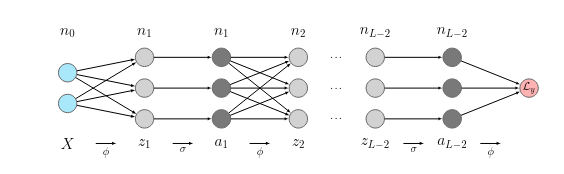)

_ProxProp_ procedure itself works similarly to a standard backpropagation procedure, as shown in the following figure.


![image.png]( 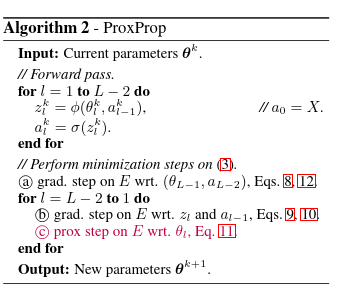)

For comparison, the standard backpropagation algorithm in this setting is as follows:


![image.png]( 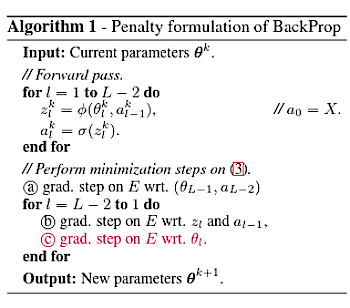)

Forward: The forward propagation phase is just as in the standard algorithm:

$z^k_l = \phi(\theta^k_l, a^k_{l−1}),$

$a^k_l = \sigma(z^k_l),$

where $\phi$ is supposed to be a linear transformation with weights $\theta^k_l$ over values $a^k_{l-1}$ and $\sigma$ is some non-linear step, e.g. the sigmoid function or the LeRU. You can use the sigmoid function for the purposes of this work.

Reverse: In the backpropagation, the step for the final layer ((a) on the figure) is exactly as in the gradient based version. In steps for the earlier layers, we recompute the z's and a's using the gradient method ((b) on the figure), but the weights are computed according to the proximal operator ((c) on the figure).

In step (a) the updated value is

$a'^{k}_{L−2} = a^k_{L−2} − \eta\nabla_{a_{L−2}} {\cal L}_y(\phi(\theta_{L−1}, a_{L−2})),$

where $\eta$ is the learning speed coefficient.

In case (b) the updated values are

$z'^{k}_l = z^k_l − \sigma'(z^k_l)(\sigma(z^k_l) − a'^k_l),$

$a'^{k}_{l−1} = a^k_{l−1} − \nabla( \frac{1}{2}\| \phi(θ^l, \cdot) − z'^k_l \|^2)(a^k_{l−1}),$

Note that the primed $a$-values are used to compute primed $z$-values and primed $z$-values are used to obtain the final value of $\theta^{k+1}$.

In case (c) the updated values are computed according to the proximal formula:

$$
\theta^{k+1}_l = \underset{\gamma}{\mathrm{argmin}} \left(\frac{1}{2} \|\phi(\gamma, a^k_{l−1}) − z'^k_l\|^2 + \frac{1}{2\tau_\theta}\|\gamma - \theta^k_l\|^2\right)
$$

The computation for the final layer is not done according to the proximity formula as it is difficult to obtain the closed formula for the necessary update, therefore it should be done according to the standard gradient descent.

The original formulas from the mentioned above paper do not use the biases. Part of the assignment is to rework this method so that the formulas include biases. You should develop a method in which biases are updated using the standard gradient descent method and the linear weight are updated using the _PropProx_ method with formulas adjusted to accommodate for biases.

# ProxProp similar to our backpropagation

Your task is to implement algorithm based on [ProxProp](https://arxiv.org/pdf/1706.04638v3). Please refer to the section above or section 4.2 in [the paper](https://arxiv.org/pdf/1706.04638v3) for algorithm description. Here we present the overview of the algorithm to be implemented.

## Forward pass

Forward pass is the same as in backpropagation implementation used in this course:
We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

Gradients $\frac{\partial L}{\partial f^{(l)}}$, $\frac{\partial L}{\partial g^{(l)}}$ need to be computed.

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$

For simplicity, biases will be updated as in standard backpropagation:
$$
%\begin{equation}
b^{(l)} = b^{(l)} - \eta \frac{\partial L}{\partial b^{(l)}}
\nonumber
%\end{equation}
$$
Remember to make the gradient update independent from the batch size by appropriate averaging!

Weights will be updated using values $f^{(l)}_{*}, g^{(l)}_{*}$. They are defined as follows:

$$
%\begin{equation}
g^{(L)}_{*} = g^{(L)} - \eta \frac{\partial L}{\partial g^{(L)}}
%\end{equation}
$$

$$
%\begin{equation}
f^{(l)}_{*} = f^{(l)} - \frac{\partial g^{(l)}}{\partial f^{(l)}} \cdot (g^{(l)} - g^{(l)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

$$
%\begin{equation}
g^{(l)}_{*} = g^{(l)} - \frac{\partial f^{(l+1)}}{\partial g^{(l)}} \cdot (f^{(l+1)} - f^{(l+1)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L - 1$.

 The update of weights is defined as:

$$
%\begin{equation}
W^{(l)} = \text{arg min}_{W} \frac{1}{2} || W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*} ||^2 + \frac{1}{2\eta} || W - W^{(l)} ||^2
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

Remarks:
* Weights are updated last (This means updated $b^{(l)}$ is used in the formula above).
* Please use closed form of the update assuming $W$ is a matrix. It might involve inverting some matrix. While it is not desirable in practice, the aim of this homework is to make you come up with the formula for the update :)
* Note that the original algorithm used two eta values. For the homework you should assume that these are equal and use for that only one parameter of the network.

## Closed form of the update
We look for $W$ such that the gradient of the function we want to minimize is $0$.
$$
%\begin{equation}
\nabla_{W} \left(\frac{1}{2} || W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*} ||^2 + \frac{1}{2\eta} || W - W^{(l)} ||^2\right)= 0 \implies
\left( W \cdot g^{(l-1)} + b^{(l)}- f_{*}^{(l)} \right)(g^{(l-1)})^T + \frac{1}{\eta}\left( W - W^{(l)} \right) = 0.
%\end{equation}
$$

Finally,
$$
%\begin{equation}
W =\left(\frac{1}{\eta}W^{(l)} + (f_*^{(l)} - b^{(l)})(g^{(l-1)})^T \right)\left(g^{(l-1)}(g^{(l-1)})^T + \frac{1}{\eta}I\right)^{-1}
%\end{equation}
$$

In [ ]:
class ProxProp(object):
    def __init__(
        self,
        sizes: List[int],
        weights: List[np.ndarray] = None,
        biases: List[np.ndarray] = None
    ) -> None:
        self.sizes = sizes
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        # IMPORTANT: use at least one layer of size a -> a
        ### Your code goes here ###
        self.num_layers = len(sizes)
        self.sizes = sizes

        if biases is not None:
            self.biases = biases
        else:
            self.biases = [np.random.randn(y, 1) for y in sizes[1:]]


        if weights is not None:
            self.weights = weights
        else:
            self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        ###########################

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network
        ### Your code goes here ###
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a
        ###########################

    def backprop(self, x: np.ndarray, y: np.ndarray, eta: float) -> float:
        ### Your code goes here ###
        mini_batch_size = x.shape[1]

        g = x
        gs = [g]
        fs = []
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)

        # backward pass <- both steps at once
        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y)

        Ws = []
        bs = []

        # First iteration for L
        dLdf = np.multiply(dLdg, np.multiply(gs[-1], 1 - gs[-1]))

        b_star = self.biases[-1] - eta * np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) / mini_batch_size
        g_star = gs[-1] - eta * dLdg
        f_star = fs[-1] - np.multiply(np.multiply(gs[-1], 1 - gs[-1]), (gs[-1] - g_star))

        first_term = (1/eta) * self.weights[-1] + ((f_star - b_star) @ gs[-2].T)
        second_term = (gs[-2] @ gs[-2].T) + (1/eta) * np.eye(gs[-2].shape[0])
        W = first_term @ np.linalg.inv(second_term)

        bs.append(b_star)
        Ws.append(W)

        dLdg = np.matmul(w.T, dLdf)

        # The rest iterations
        for w, w_next, b, g, g_prev, f, f_next in list(reversed(list(zip(self.weights[:-1], self.weights[1:], self.biases[:-1], gs[1:-1], gs[:-2], fs[:-1], fs[1:])))):
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))

            # Proximal variables
            b_star = b - eta * np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) / mini_batch_size
            g_star = g - np.matmul(w_next.T, f_next - f_star)
            f_star = f - np.multiply(np.multiply(g, 1 - g), (g - g_star))

            # Derived formula for W
            first_term = (1/eta) * w + ((f_star - b_star) @ g_prev.T)
            second_term = (g_prev @ g_prev.T) + (1/eta) * np.eye(g_prev.shape[0])
            W = first_term @ np.linalg.inv(second_term)

            bs.append(b_star)
            Ws.append(W)

            dLdg = np.matmul(w.T, dLdf)

        # Update weights and biases
        self.weights = list(reversed(Ws))
        self.biases = list(reversed(bs))

        return loss
        ###########################

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        wloss = logloss(self.feedforward(x_train).T, y_train) / (
            x_train.shape[0] // mini_batch_size
        )
        for j in range(epochs + 1):
            if logger is not None:
                logger.report_scalar("Loss", "ProxProp Loss", iteration = j, value = wloss)
            if test_data:
                acc = self.evaluate((x_test, y_test))
                if logger is not None:
                    logger.report_scalar("Accuracy", "ProxProp Accuracy", iteration=j, value=acc)
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if j == epochs:
                break
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    i * mini_batch_size : (i * mini_batch_size + mini_batch_size)
                ]
                y_mini_batch = y_train[
                    i * mini_batch_size : (i * mini_batch_size + mini_batch_size)
                ]
                loss += self.backprop(x_mini_batch.T, y_mini_batch.T, eta)
            wloss = loss / (x_train.shape[0] // mini_batch_size)


# Simple check if all is fine
network = ProxProp([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.0971, Loss: 11.012985598307779
Epoch: 1, Accuracy: 0.8645, Loss: 0.842261766097797
Epoch: 2, Accuracy: 0.9012, Loss: 0.42147709335490097


# Train the network

In [ ]:
### Your code goes here ###

# We set the seed to make the initialization of weights and biases the same for both networks.
seed = 1234

task.connect(params_proxprop, name="ProxProp")
task.connect(params_network, name="Network")

logger = task.get_logger()

# I found eta for basic_network using optuna.
np.random.seed(seed)
proxprop_network = ProxProp(params_proxprop['layers'])
np.random.seed(seed)
basic_network = Network(params_network['layers'])
print("Models weights and biases equal: ",
      all(np.array_equal(b1, b2) for b1, b2 in zip(basic_network.biases, proxprop_network.biases))
       and all(np.array_equal(w1, w2) for w1, w2 in zip(basic_network.weights, proxprop_network.weights)))


print("\nProxProp training:")
proxprop_network.SGD(
    (x_train, y_train),
    epochs=params_proxprop['epochs'],
    mini_batch_size=params_proxprop['mini_batch_size'],
    eta=params_proxprop['learning_rate'],
    test_data=(x_test, y_test),
    logger=logger
)

print("\nNetwork training")
basic_network.SGD(
    (x_train, y_train),
    epochs=params_network['epochs'],
    mini_batch_size=params_network['mini_batch_size'],
    eta=params_network['learning_rate'],
    test_data=(x_test, y_test),
    logger=logger
)

task.close()
###########################

Models weights and biases equal:  True

ProxProp training:
Epoch: 0, Accuracy: 0.1043, Loss: 14.127843172769293
Epoch: 1, Accuracy: 0.143, Loss: 0.7794058692360909
Epoch: 2, Accuracy: 0.9238, Loss: 0.5510510180119518
Epoch: 3, Accuracy: 0.9355, Loss: 0.4566898809840644
Epoch: 4, Accuracy: 0.938, Loss: 0.3858346969728715
Epoch: 5, Accuracy: 0.9429, Loss: 0.3397837227170243
Epoch: 6, Accuracy: 0.9454, Loss: 0.3079894369898177
Epoch: 7, Accuracy: 0.9461, Loss: 0.2921345049545519
Epoch: 8, Accuracy: 0.9462, Loss: 0.2726186019719901
Epoch: 9, Accuracy: 0.9467, Loss: 0.2594284141241721
Epoch: 10, Accuracy: 0.9494, Loss: 0.25081057251802374
Epoch: 11, Accuracy: 0.9496, Loss: 0.23389206653982644

Network training
Epoch: 0, Accuracy: 0.1043, Loss: 14.127843172769293
Epoch: 1, Accuracy: 0.5898, Loss: 7.386937554439967
Epoch: 2, Accuracy: 0.7368, Loss: 4.065757788891323
Epoch: 3, Accuracy: 0.7541, Loss: 3.1862453692947734
Epoch: 4, Accuracy: 0.7609, Loss: 3.049104260589066
Epoch: 5, Accuracy: 0.8

In [ ]:
print(f"Final accuracy:\nProxProp: {proxprop_network.evaluate((x_test, y_test))},\nBasic:{basic_network.evaluate((x_test, y_test))}.")

Final accuracy:
ProxProp: 0.9496,
Basic:0.8496.


# Unit tests for _ProxyProp_

In [ ]:
# Generate test cases like below
import numpy as np
np.random.seed(1234)

sizes=[784, 50, 40, 30, 10]
proxprop = ProxProp(sizes=sizes)

np.savez("sizes", sizes=np.array(sizes))
np.savez("weights.npz", *proxprop.weights)
np.savez("biases.npz", *proxprop.biases)

####
a = np.random.normal(0, 1, (3,784))
expected_output = proxprop.feedforward(a=a)

np.savez("feedforward_1.npz", a=a, expected_output=expected_output)

####
a = np.random.normal(0, 1, (5,784))
expected_output = proxprop.feedforward(a=a)

np.savez("feedforward_2.npz", a=a, expected_output=expected_output)

####
x = np.random.normal(0, 1, (784, 5))
y = np.zeros((10, 5))
for i in range(5):
    y[i][i] = 1
eta = 0.001
expected_output = proxprop.backprop(x=x, y=y, eta=eta)

np.savez("backward_1.npz", x=x, y=y, eta=np.array(eta), expected_output=expected_output)
np.savez("backward_1_weights.npz", *proxprop.weights)
np.savez("backward_1_biases.npz", *proxprop.biases)

In [ ]:
import unittest
import requests
import io
from typing import Literal


class TestProxyProp(unittest.TestCase):
    @staticmethod
    def _load_data(url: str, mode: Literal["local", "remote"]) -> list[np.ndarray]:
        if mode == "remote":
            response = requests.get(url)
            response.raise_for_status()
            buffer = io.BytesIO(response.content)
            buffer.seek(0)
        elif mode == "local":
            with open(url, "rb") as f:
                buffer = io.BytesIO(f.read())
        else:
            raise ValueError(f"Inocrrect mode {mode}")

        buffer.seek(0)
        return np.load(buffer)

    def test_feedforward(self) -> None:
        test_case_dicts: list[dict[str, str]] = [
            {
                "test_case": "feedforward_1.npz",
                "sizes": "sizes.npz",
                "weights": "weights.npz",
                "biases": "biases.npz",
                "mode": "local",
            },
            {
                "test_case": "feedforward_2.npz",
                "sizes": "sizes.npz",
                "weights": "weights.npz",
                "biases": "biases.npz",
                "mode": "local",
            },
        ]

        for test_case_dict in test_case_dicts:
            self.feedforward_single_case(test_case=test_case_dict)


    def feedforward_single_case(self, test_case: dict[str, str]) -> None:
        # given
        sizes = self._load_data(url=test_case["sizes"], mode=test_case["mode"])["sizes"].tolist()
        weights_npz = self._load_data(url=test_case["weights"], mode=test_case["mode"])
        biases_npz = self._load_data(url=test_case["biases"], mode=test_case["mode"])

        weights = [weights_npz[x] for x in weights_npz]
        biases = [biases_npz[x] for x in biases_npz]

        test_case_data = self._load_data(url=test_case["test_case"], mode=test_case["mode"])
        a = test_case_data["a"]
        expected_output = test_case_data["expected_output"]

        proxprop = ProxProp(
            sizes=sizes,
            weights=weights,
            biases=biases,
        )

        # when
        output = proxprop.feedforward(a=a)

        # then
        np.testing.assert_array_equal(output, expected_output)

    def test_backprop(self) -> None:
        test_case_dicts: list[dict[str, str]] = [
            {
                "test_case": "backward_1.npz",
                "output_weights": "backward_1_weights.npz",
                "output_biases": "backward_1_biases.npz",
                "sizes": "sizes.npz",
                "weights": "weights.npz",
                "biases": "biases.npz",
                "mode": "local",
            },
        ]

        for test_case_dict in test_case_dicts:
            self.backprop_single_case(test_case=test_case_dict)

    def backprop_single_case(self, test_case: dict[str, str]) -> None:
        # given
        sizes = self._load_data(url=test_case["sizes"], mode=test_case["mode"])["sizes"].tolist()
        weights_npz = self._load_data(url=test_case["weights"], mode=test_case["mode"])
        biases_npz = self._load_data(url=test_case["biases"], mode=test_case["mode"])

        weights = [weights_npz[x] for x in weights_npz]
        biases = [biases_npz[x] for x in biases_npz]

        test_case_data = self._load_data(url=test_case["test_case"], mode=test_case["mode"])
        x = test_case_data["x"]
        y = test_case_data["y"]
        expected_output = test_case_data["expected_output"]
        eta = test_case_data["eta"].item()

        output_weights_npz = self._load_data(url=test_case["output_weights"], mode=test_case["mode"])
        output_biases_npz = self._load_data(url=test_case["output_biases"], mode=test_case["mode"])

        output_weights = [weights_npz[x] for x in output_weights_npz]
        output_biases = [biases_npz[x] for x in output_biases_npz]


        proxprop = ProxProp(
            sizes=sizes,
            weights=weights,
            biases=biases,
        )

        # when
        output = proxprop.backprop(x=x, y=y, eta=eta)

        # then
        np.testing.assert_array_equal(output, expected_output)

        for w, ew in zip(proxprop.weights, output_weights):
            np.testing.assert_allclose(w, ew, rtol=5e-4)

        for  b, eb in zip(proxprop.biases, output_biases):
            np.testing.assert_allclose(b, eb, rtol=5e-4)


res = unittest.main(argv=[''], verbosity=2, exit=False)
assert len(res.result.failures) == 0

test_backprop (__main__.TestProxyProp) ... FAIL
test_feedforward (__main__.TestProxyProp) ... ok

FAIL: test_backprop (__main__.TestProxyProp)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-13-1c8ebf9e2b63>", line 85, in test_backprop
    self.backprop_single_case(test_case=test_case_dict)
  File "<ipython-input-13-1c8ebf9e2b63>", line 125, in backprop_single_case
    np.testing.assert_allclose(b, eb, rtol=5e-4)
  File "/usr/local/lib/python3.10/dist-packages/numpy/testing/_private/utils.py", line 1504, in assert_allclose
    assert_array_compare(compare, actual, desired, err_msg=str(err_msg),
  File "/usr/lib/python3.10/contextlib.py", line 79, in inner
    return func(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/numpy/testing/_private/utils.py", line 797, in assert_array_compare
    raise AssertionError(msg)
AssertionError: 
Not equal to tolerance rtol=0.0005, atol=0

Mismatched elemen

AssertionError: 

# Training plots for the best training

In [ ]:
task = Task.get_task(
    project_name='hw1-proxprop',
    task_name='Track experiment progress',
)

metrics = task.get_reported_scalars()
print(metrics.keys())

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("Training Loss", "Test Accuracy"))

fig.add_trace(go.Scatter(x=metrics['Loss']['ProxProp Loss']['x'],
                         y=metrics['Loss']['ProxProp Loss']['y'],
                         name='ProxProp Train Loss'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=metrics['Accuracy']['ProxProp Accuracy']['x'],
                         y=metrics['Accuracy']['ProxProp Accuracy']['y'],
                         name='ProxProp Test Accuracy'),
              row=1, col=2)

fig.add_trace(go.Scatter(x=metrics['Loss']['Network Loss']['x'],
                         y=metrics['Loss']['Network Loss']['y'],
                         name='Network Train Loss'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=metrics['Accuracy']['Network Accuracy']['x'],
                         y=metrics['Accuracy']['Network Accuracy']['y'],
                         name='Network Test Accuracy'),
              row=1, col=2)

fig.update_layout(title='Training Metrics',
                  xaxis_title='Epoch',
                  yaxis_title='Value')

fig.show()
###########################

24 task found when searching for `{'project_name': 'hw1-proxprop', 'task_name': 'Track experiment progress', 'include_archived': True}`
Selected task `Track experiment progress` (id=821665df99c345aaabe51325a97fa24d)


dict_keys([':monitor:machine', 'Accuracy', 'Loss'])


# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

In [ ]:
### Your code goes here ###
from memory_profiler import memory_usage

seed = 1234

np.random.seed(seed)
network_memory = Network(params_network['layers'])
np.random.seed(seed)
proxprop_memory = ProxProp(params_proxprop['layers'])

print("Network training:")
memory_usage_network = memory_usage((network_memory.SGD, ([x_train, y_train],
                                            3,
                                            params_network['mini_batch_size'],
                                            params_network['learning_rate'],
                                            [x_test, y_test],
                                            None)),
                                     interval=0.01)
print("\nProxProp training:")
memory_usage_proxprop = memory_usage((proxprop_memory.SGD, ([x_train, y_train],
                                            3,
                                            params_proxprop['mini_batch_size'],
                                            params_proxprop['learning_rate'],
                                            (x_test, y_test),
                                            None)),
                                     interval=0.01)
###########################

Network training:
Epoch: 0, Accuracy: 0.1043, Loss: 14.127843172769293
Epoch: 1, Accuracy: 0.5898, Loss: 7.386937554439967
Epoch: 2, Accuracy: 0.7368, Loss: 4.065757788891323
Epoch: 3, Accuracy: 0.7541, Loss: 3.1862453692947734

ProxProp training:
Epoch: 0, Accuracy: 0.1043, Loss: 14.127843172769293
Epoch: 1, Accuracy: 0.143, Loss: 0.7794058692360909
Epoch: 2, Accuracy: 0.9238, Loss: 0.5510510180119518
Epoch: 3, Accuracy: 0.9355, Loss: 0.4566898809840644


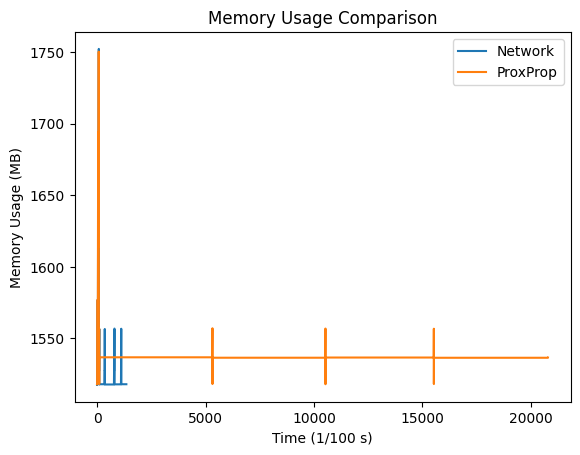


Mean memory usage for Network:1525.429592084567, for ProxProp 1537.0153232038053


In [ ]:
plt.plot(memory_usage_network, label='Network')
plt.plot(memory_usage_proxprop, label='ProxProp')

plt.xlabel('Time (1/100 s)')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage Comparison')
plt.legend()

plt.show()

print(f"\nMean memory usage for Network:{np.mean(memory_usage_network)}, for ProxProp {np.mean(memory_usage_proxprop)}")

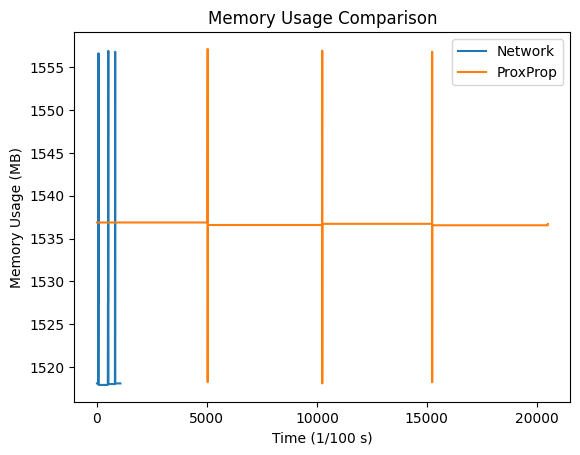


Mean memory usage for Network:1518.9460966815197, for ProxProp 1536.685963374


In [ ]:
memory_usage_network_cp = memory_usage_network[285:]
memory_usage_proxprop_cp = memory_usage_proxprop[285:]

plt.plot(memory_usage_network_cp, label='Network')
plt.plot(memory_usage_proxprop_cp, label='ProxProp')

plt.xlabel('Time (1/100 s)')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage Comparison')
plt.legend()

plt.show()

print(f"\nMean memory usage for Network:{np.mean(memory_usage_network_cp)}, for ProxProp {np.mean(memory_usage_proxprop_cp)}")

I have two plots because the first one may distort the memory usage image due to an explosion of memory usage at epoch 0. This may occur because the `wloss` in epoch 0 is calculated before the optimizer step, meaning it is based on random values, which seems to be the only difference between epoch 0 and the rest of the epochs. In contrast, when `wloss` is calculated after the optimizer step, this issue does not occur.

The memory usage comparison between standard backpropagation and ProxProp reveals that while both algorithms show fluctuations, ProxProp has lower amplitude in its fluctuations, maintaining memory usage close to its mean value for most of the process. In contrast, standard backpropagation exhibits higher fluctuations, alternating between lower and higher memory usage. Although the mean memory usage is similar for both algorithms, ProxProp provides a higher, more stable memory profile. However, each ProxProp iteration takes longer due to the need to solve a linear equation, and in this implementation, an inverted matrix is calculated instead, as specified in the task.